<a href="https://colab.research.google.com/github/khushidubeyokok/PyTorch/blob/main/06/Transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer learning
## Transfer learning allows us to take the patterns (also called weights) another model has learned from another problem and use them for our own problem.
### In this notebook, we can take the patterns a computer vision model ([efficientnet_b0](https://pytorch.org/vision/stable/models/generated/torchvision.models.efficientnet_b0.html)) has learned from datasets such as ImageNet (millions of images of different objects) and use them to power our FoodVision Mini model.

## Import required python scripts from [notebook 05](https://github.com/khushidubeyokok/PyTorch/tree/main/05/going_modular)

In [1]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    !git clone https://github.com/khushidubeyokok/PyTorch.git
    !mv PyTorch/05/going_modular .
    !rm -rf PyTorch
    from going_modular import data_setup, engine

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular scripts... downloading them from GitHub.
Cloning into 'PyTorch'...
remote: Enumerating objects: 174, done.
remote: Counting objects: 100% (23/23), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 174 (delta 7), reused 4 (delta 4), pack-reused 151 (from 1)
Receiving objects: 100% (174/174), 6.35 MiB | 6.53 MiB/s, done.
Resolving deltas: 100% (66/66), done.


In [2]:
# setup device agnostic code
device = 'cuda ' if torch.cuda.is_available() else 'cpu'
device

'cpu'

## Get data.
we need our pizza,steak,sushi model to build a transfer learning model

In [3]:
import os
import zipfile
import requests
from pathlib import Path

data_path=Path('data/')
image_path=data_path/'pizza_steak_sushi'
if not image_path.is_dir():
  print('donwloading image_path')
  image_path.mkdir(parents=True,exist_ok=True)

with open(data_path/'pizza-steak-sushi.zip','wb') as f:
  print(f"downloading zip file")
  request=requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
  f.write(request.content)

with zipfile.ZipFile(data_path/'pizza-steak-sushi.zip','r') as zip_ref:
  print('unzipping')
  zip_ref.extractall(image_path)

#remove zip file
os.remove(data_path/'pizza-steak-sushi.zip')

donwloading image_path
downloading zip file
unzipping


In [4]:
train_dir=image_path/'train'
test_dir=image_path/'test'

train_dir,test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

## Create dataset and dataloaders
to do so we will leverage the modules `data_setup.py` and `create_dataloaders()`
>When using a pretrained model, it's important that your custom data going into the model is prepared in the same way as the original training data that went into the model.
> Transform can be done manualy or automatically


### Creating a transform for `torchvision.models` (manually)
>All pre-trained models expect input images normalized in the same way, i.e. mini-batches of 3-channel RGB images of shape (3 x H x W), where H and W are expected to be at least 224.

The images have to be loaded in to a range of [0, 1] and then normalized using mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225].

In [5]:
from torchvision import transforms
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

manual_transform=transforms.Compose([transforms.Resize((224,224)), #resize image
                              transforms.ToTensor(), #get images in range [0,1]
                              normalize #make sure images have the same distribution as ImageNet
                              ])

In [6]:
from going_modular import data_setup

train_dataloader,test_dataloader,class_names=data_setup.create_dataloaders(train_dir,test_dir,manual_transform,32)
train_dataloader,test_dataloader,class_names

8,3


(<torch.utils.data.dataloader.DataLoader at 0x7c49daf08100>,
 ['pizza', 'steak', 'sushi'])

### Creating a transform for `torchvision.models` (auto creation)

In [7]:
#get a set of pretained model weights
weights=torchvision.models.EfficientNet_B0_Weights.DEFAULT # DEFAULT = best available weights
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [8]:
# get the auto transform
auto_transform=weights.transforms()
auto_transform

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [9]:
from going_modular import data_setup

train_dataloader,test_dataloader,class_names=data_setup.create_dataloaders(train_dir,test_dir,auto_transform,32)
train_dataloader,test_dataloader,class_names

8,3


(<torch.utils.data.dataloader.DataLoader at 0x7c49daf09ae0>,
 ['pizza', 'steak', 'sushi'])

## Getting a pretrained model
There are various places to get a pretrained model such as :
1. Pytorch Domain libraries
2. Libraries like `timm`(torch image models)
3. Hugging face hub
4. PapersWithCode

###  Which pretrained model should you use?
Experiment, experiment, experiment!

The whole idea of transfer learning: take an already well-performing model from a problem space similar to your own and then customize to your own problem.

Three things to consider:

1. Speed - how fast does it need to run?
2. Size - how big is the model?
3. Performance - how well does it go on your chosen problem (e.g. how well does it classify food images? for FoodVision Mini)?
4. Where does the model live?
Is it on device? (like a self-driving car) Or does it live on a server?

Looking at https://pytorch.org/vision/main/models.html#table-of-all-available-classification-weights

For our case (deploying FoodVision Mini on a mobile device), it looks like EffNetB0 is one of our best options in terms performance vs size.

### Setting up a pretrained model
We aim to create a instance of pretrained [Efficientnet_b0](https://pytorch.org/vision/stable/models/generated/torchvision.models.efficientnet_b0.html) model

In [10]:
weights=torchvision.models.EfficientNet_B0_Weights.DEFAULT
model=torchvision.models.efficientnet_b0(weights=weights,progress=True).to(device)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 64.9MB/s]


In [11]:
model.classifier #since it is trained on ImageNet , the out_features is 1000

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

### Types of pretained model
1. Original model
2. Feature extraction (we will leverage this)
3. Fine tuning

### Getting a summary of our model using `torchinfo`

In [12]:
from torchinfo import summary
summary(model=model,
        input_size=[1,3,224,224],
        col_names=['input_size','output_size','num_params','trainable'],
        col_width=20,
        row_settings=['var_names'])

## Here we can see all the layers are trainable which leads to higher computation and hence not the idle case for us

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 1000]            --                   True
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   True
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   True
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    864                  True
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    64                   True
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 16, 112,

### Freezing the base layer and updating the classifier layer
> Feature extraction model

In [13]:
# Freeze all the base layers in EffNetB0
for param in model.features.parameters():
  param.requires_grad=False

In [14]:
from torchinfo import summary
summary(model=model,
        input_size=[1,3,224,224],
        col_names=['input_size','output_size','num_params','trainable'],
        col_width=20,
        row_settings=['var_names'])


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 1000]            --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

In [15]:
# Update the classifier head of our model to suit our problem
from torch import nn
torch.manual_seed(42)
torch.cuda.manual_seed(42)

print(f"before:{model.classifier}")
model.classifier=nn.Sequential(nn.Dropout(p=0.2,inplace=True),
                               nn.Linear(in_features=1280 ,#feature vector coming in
                                         out_features=len(class_names))).to(device)
print(f"after:{model.classifier}")

before:Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)
after:Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=3, bias=True)
)


In [16]:
# Get a summary of our feature extraction model
summary(model=model,
        input_size=[1,3,224,224],
        col_names=['input_size','output_size','num_params','trainable'],
        col_width=20,
        row_settings=['var_names'])


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

## Train the model

In [17]:
#define loss function and optimiser
from torch import nn
lossfn=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(params=model.parameters(),lr=0.001)

In [18]:
from going_modular import engine
torch.manual_seed(42)
torch.cuda.manual_seed(42)

#start timer
from timeit import default_timer as timer
start=timer()

results=engine.train_and_test_model(model=model,epochs=5,train_dataloader=train_dataloader,test_dataloader=test_dataloader,loss_function=lossfn,optimiser=optimizer,device=device)

end=timer()
print(f"total traning time:{end-start:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0966 | train_acc: 38.6719% | test_loss: 0.8720 | test_acc: 72.2538%
Epoch: 2 | train_loss: 0.8693 | train_acc: 78.1250% | test_loss: 0.7726 | test_acc: 83.5227%
Epoch: 3 | train_loss: 0.8146 | train_acc: 71.0938% | test_loss: 0.7203 | test_acc: 82.6705%
Epoch: 4 | train_loss: 0.7052 | train_acc: 75.3906% | test_loss: 0.5953 | test_acc: 87.5947%
Epoch: 5 | train_loss: 0.6077 | train_acc: 75.0000% | test_loss: 0.5927 | test_acc: 90.6250%
time_taken:189.49052085899996
total traning time:189.568 seconds


## Evaluate our model by plotting loss curve

In [19]:
try:
  from helper_function import plot_loss_curves
  print('helper_function exists')

except:
  print('downloading')
  import requests
  from pathlib import Path
  helper_function_path=Path('helper_function.py')
  with open(helper_function_path,'wb') as f:
    request=requests.get('https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/refs/heads/main/helper_functions.py')
    f.write(request.content)
  from helper_function import plot_loss_curves

downloading


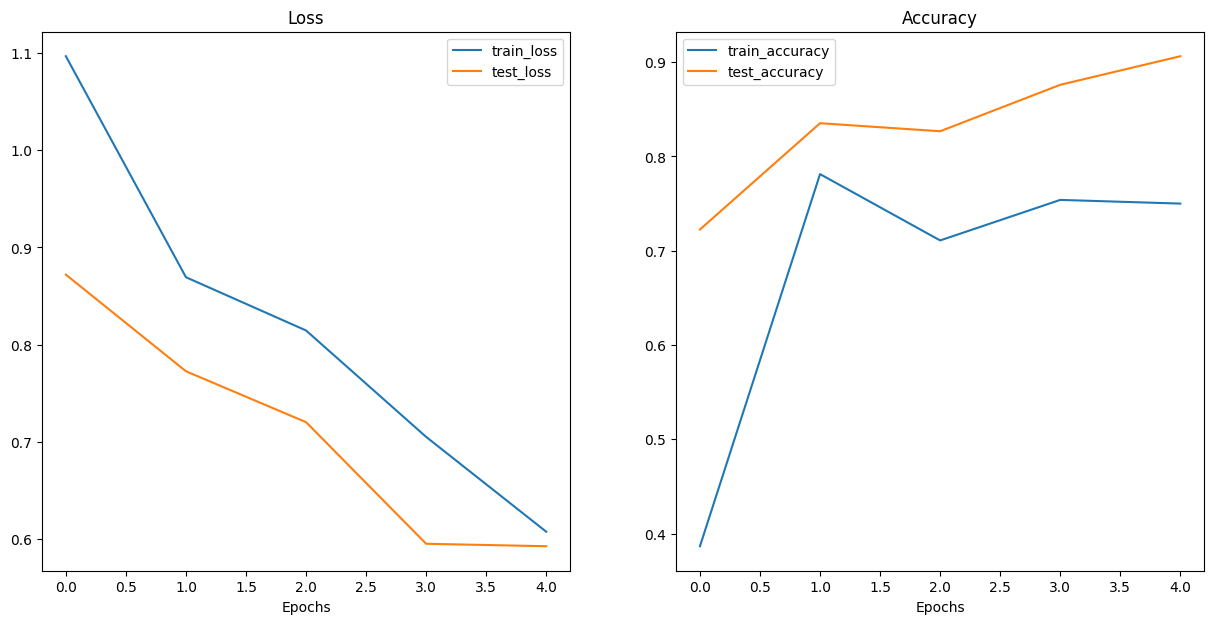

In [20]:
plot_loss_curves(results)

## Make predictions on images from test set
### We have to make sure that our data is
- same shape
- same datatype
- same device
- same transform

In [21]:
def pred_and_plot_image(model,class_names,image_path,image_size,transform=None,device=device):
  from PIL import Image
  import torch
  from torch import nn
  import matplotlib.pyplot as plt

  img=Image.open(image_path)
  if transform is not None:
    transform=transform
  else:
    transform=transforms.Compose([transforms.Resize((224,224)), #resize image
                              transforms.ToTensor(), #get images in range [0,1]
                              normalize #make sure images have the same distribution as ImageNet
                              ])

  transformed_img=transform(img).unsqueeze(dim=0)
  model=model.to(device)
  model.eval()
  with torch.inference_mode():
    y_logit=model(transformed_img.to(device))
    y_pred=torch.argmax(torch.softmax(y_logit,dim=1),dim=1)

  plt.figure()
  plt.imshow(img)
  plt.title(class_names[y_pred])
  plt.axis(False)

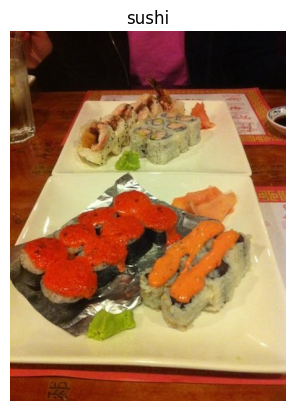

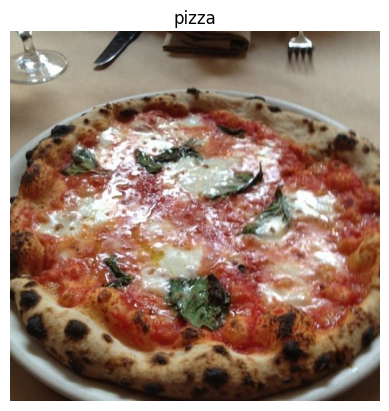

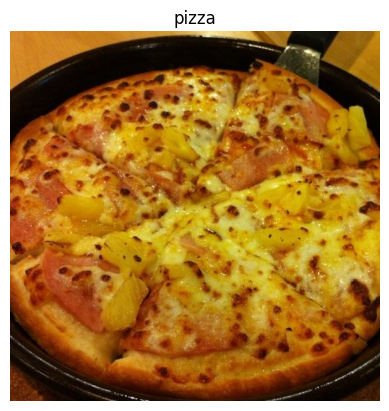

In [22]:
#get random images from test set
import random
num_images_to_plot=3
test_image_path=list(Path(test_dir).glob('*/*.jpg'))
random_image_path=random.sample(population=test_image_path,k=num_images_to_plot)

for image_path in random_image_path:
  pred_and_plot_image(model,class_names,image_path,(224,224))

### Making prediction on custom image

In [23]:
import requests

custom_image_path=data_path/'custom.jpg'

if not custom_image_path.is_file():
  with open(custom_image_path,'wb') as f:
    request=requests.get('https://t3.ftcdn.net/jpg/01/82/10/36/360_F_182103675_Eg6dqvyNvIKgOYZRDwfXruFhcIG1q5nu.jpg')
    f.write(request.content)
else:
  print('already exits')

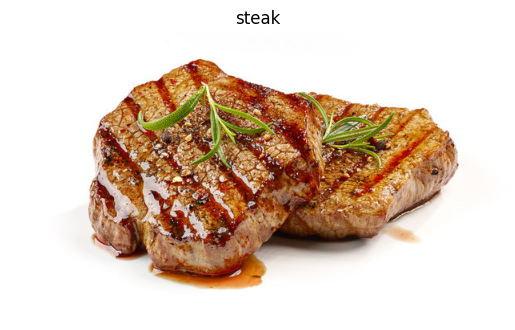

In [24]:
pred_and_plot_image(model,class_names,custom_image_path,(224,224))